In [1]:
import numpy as np
import os
from rp_csv import FaceMeshDetector
import pandas as pd
import cv2
import mediapipe
import time
import random
from PIL import Image
from sklearn.utils import class_weight
import tensorflow as tf
from keras.applications.resnet import ResNet152, ResNet50, ResNet101
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition, svm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    InputLayer,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    RandomFourierFeatures,
    Input,
)
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

input_shape = (465, 930, 3)

# Define hyperparameters and their values for GridSearch
param_grid = {
    'learning_rate': [0.0001, 0.001],
    'hidden_layers': [1, 2],
}

combinations = [[0,0], [0,1], [1,0], [1,1]]

# Define hyperparameters and their values for GridSearch
param_grid2 = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate':  [0, 0.2],
    'hidden_layers': [1, 2],
}

combinations2 = [[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]

param_grid3 = {
    'conv_layers': [2, 3],
    #'dense_layers':  [1, 2],
    'epochs': [5, 10, 20],
}

combinations3 = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

# Preprocessing data (assuming train, valid and test directories are already generated)

### Batches:

In [3]:
train_path = "rp_data/train"
valid_path = "rp_data/valid"
test_path = "rp_data/test"

# Define image size and number of channels
img_height = 465
img_width = 930

# Change preprocess_input to the corresponding classifier (vgg16, resnet etc.)
train_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,
    target_size=(img_height, img_width),
    classes=["normal", "stroke"],
    batch_size=8,
)

valid_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,
    target_size=(img_height, img_width),
    classes=["normal", "stroke"],
    batch_size=8,
)
test_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,
    target_size=(img_height, img_width),
    classes=["normal", "stroke"],
    batch_size=8,
    shuffle=False,
)

Found 3537 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


### Numpy arrays:

In [9]:
# Using numpy arrays instead:

train_path_normal = "rp_data/train/normal"
train_path_stroke = "rp_data/train/stroke"
valid_path_normal = "rp_data/valid/normal"
valid_path_stroke = "rp_data/valid/stroke"
test_path_normal = "rp_data/test/normal"
test_path_stroke = "rp_data/test/stroke"

# Define image size and number of channels
height = 465
width = 930

# --- Training dataset --- #

train_images = []
train_labels = []

for filename in os.listdir(train_path_normal):
    # Load the image using PIL
    img = Image.open(os.path.join(train_path_normal, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    train_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    train_labels.append(0)

for filename in os.listdir(train_path_stroke):
    # Load the image using PIL
    img = Image.open(os.path.join(train_path_stroke, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    train_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    train_labels.append(1)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_images = train_images.reshape(-1, height*width)
train_labels = train_labels.reshape(-1)
train_labels = train_labels.astype(int)
print(train_labels)
print("Training images and labels:", train_images.shape, train_labels.shape)

# Shuffle:

# Combine the train_images and train_labels list using zip
combined = list(zip(train_images, train_labels))
# Shuffle the combined list
random.shuffle(combined)
# Separate the shuffled images and labels list
train_images, train_labels = zip(*combined)
train_images = np.array(train_images)
train_labels = np.array(train_labels)


[0 0 0 ... 1 1 1]
Training images and labels: (3537, 432450) (3537,)


In [10]:
# --- Validation dataset --- #

valid_images = []
valid_labels = []

for filename in os.listdir(valid_path_normal):
    # Load the image using PIL
    img = Image.open(os.path.join(valid_path_normal, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    valid_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    valid_labels.append(0)

for filename in os.listdir(valid_path_stroke):
    # Load the image using PIL
    img = Image.open(os.path.join(valid_path_stroke, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    valid_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    valid_labels.append(1)

valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
valid_images = valid_images.reshape(-1, height*width)
valid_labels = valid_labels.reshape(-1)
valid_labels = valid_labels.astype(int)

print("Validation images and labels:", valid_images.shape, valid_labels.shape)

# Shuffle:

# Combine the train_images and train_labels list using zip
combined = list(zip(valid_images, valid_labels))
# Shuffle the combined list
random.shuffle(combined)
# Separate the shuffled images and labels list
valid_images, valid_labels = zip(*combined)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

Validation images and labels: (585, 432450) (585,)


In [11]:
# --- Test dataset --- #

test_images = []
test_labels = []

for filename in os.listdir(test_path_normal):
    # Load the image using PIL
    img = Image.open(os.path.join(test_path_normal, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    test_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    test_labels.append(0)

for filename in os.listdir(test_path_stroke):
    # Load the image using PIL
    img = Image.open(os.path.join(test_path_stroke, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    test_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    test_labels.append(1)

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images = test_images.reshape(-1, height*width)
test_labels = test_labels.reshape(-1)
test_labels = test_labels.astype(int)

print("Testing images and labels:", test_images.shape, test_labels.shape)

Testing images and labels: (51, 432450) (51,)


# Data for SVM

In [11]:
video_path = "D:\\Kandidatarbete\\Dataset Face\\non-stroke\\mouth"
x = []
for i, filename in enumerate(os.listdir(video_path)):
    # Specify your path to your video file here + other ariables for quick editing
    # save_name = "D:\\Kandidatarbete\\denna2\\weak19"
    # max_frame_length = 86
    # Use video_path or 0 for webcam
    cap = cv2.VideoCapture(video_path + "\\" + filename)
    pTime = 0
    detector = FaceMeshDetector()
    euc_distance_left = []
    euc_distance_right = []
    # Loop through each video frame
    # for i in range(max_frame_length):
    while True:
        success, img = cap.read()
        # Stop the program if video ends or a frame cannot be read
        if not success:
            break
        img, faces, euc_l, euc_r = detector.findFaceMesh(
            img, euc_distance_left, euc_distance_right
        )
        # Fps counter
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        cv2.putText(
            img,
            f"MediaPipe - FPS: {int(fps)}",
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            3,
            (0, 255, 0),
            3,
        )
        cv2.imshow("face_cam", img)
        # Exit if the 'q' key is pressed, use waitKey(1) for fastest fps
        if cv2.waitKey(2) & 0xFF == ord("q"):
            print("Quitting video...")
            break
    cap.release()
    cv2.destroyAllWindows()
    
    ## Recurrence data ##
    # euc_l = np.array(euc_l)
    # euc_r = np.array(euc_r)
    x.append(list(zip(euc_l, euc_r)))
    # For debugging
    print("Videos found:", i + 1)


Videos found: 1
Videos found: 2
Videos found: 3
Videos found: 4
Videos found: 5
Videos found: 6
Videos found: 7
Videos found: 8
Videos found: 9
Videos found: 10
Videos found: 11
Videos found: 12
Videos found: 13
Videos found: 14
Videos found: 15
Videos found: 16
Videos found: 17
Videos found: 18
Videos found: 19
Videos found: 20
Videos found: 21
Videos found: 22
Videos found: 23
Videos found: 24
Videos found: 25
Videos found: 26
Videos found: 27
Videos found: 28
Videos found: 29
Videos found: 30
Videos found: 31


In [12]:
video_path = "D:\\Kandidatarbete\\Dataset Face\\stroke\\mouth"
for i, filename in enumerate(os.listdir(video_path)):
    # Specify your path to your video file here + other ariables for quick editing
    # save_name = "D:\\Kandidatarbete\\denna2\\weak19"
    # max_frame_length = 86
    # Use video_path or 0 for webcam
    cap = cv2.VideoCapture(video_path + "\\" + filename)
    pTime = 0
    detector = FaceMeshDetector()
    euc_distance_left = []
    euc_distance_right = []
    # Loop through each video frame
    # for i in range(max_frame_length):
    while True:
        success, img = cap.read()
        # Stop the program if video ends or a frame cannot be read
        if not success:
            break
        img, faces, euc_l, euc_r = detector.findFaceMesh(
            img, euc_distance_left, euc_distance_right
        )
        # Fps counter
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        cv2.putText(
            img,
            f"MediaPipe - FPS: {int(fps)}",
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            3,
            (0, 255, 0),
            3,
        )
        cv2.imshow("face_cam", img)
        # Exit if the 'q' key is pressed, use waitKey(1) for fastest fps
        if cv2.waitKey(2) & 0xFF == ord("q"):
            print("Quitting video...")
            break
    cap.release()
    cv2.destroyAllWindows()
    
    ## Recurrence data ##
    # euc_l = np.array(euc_l)
    # euc_r = np.array(euc_r)
    x.append(list(zip(euc_l, euc_r)))
    # For debugging
    print("Videos found:", i + 1)




Videos found: 1
Videos found: 2
Videos found: 3
Videos found: 4
Videos found: 5
Videos found: 6
Videos found: 7
Videos found: 8
Videos found: 9
Videos found: 10
Videos found: 11
Videos found: 12
Videos found: 13
Videos found: 14
Videos found: 15
Videos found: 16
Videos found: 17
Videos found: 18
Videos found: 19
Videos found: 20
Videos found: 21
Videos found: 22
Videos found: 23
Videos found: 24
Videos found: 25
Videos found: 26
Videos found: 27
Videos found: 28
Videos found: 29
Videos found: 30
Videos found: 31
Videos found: 32
Videos found: 33
Videos found: 34
Videos found: 35
Videos found: 36
Videos found: 37
Videos found: 38
Videos found: 39
Videos found: 40
Videos found: 41
Videos found: 42
Videos found: 43
Videos found: 44
Videos found: 45
Videos found: 46
Videos found: 47
Videos found: 48
Videos found: 49
Videos found: 50
Videos found: 51
Videos found: 52
Videos found: 53
Videos found: 54
Videos found: 55
Videos found: 56
Videos found: 57
Videos found: 58
Videos found: 59
Videos

In [19]:

def add_padding_and_normalize(input_list):
    # Find the length of the longest list
    max_len = max(len(lst) for lst in input_list)

    # Add tuples with (0,0) to any list that is shorter than max_len
    padded_list = []
    for lst in input_list:
        padded_lst = lst + [(0, 0)] * (max_len - len(lst))
        padded_list.append(padded_lst)

    # Convert the padded list to a NumPy array
    arr = np.array(padded_list)

    # Compute the L2 norm of each tuple in the array
    norm_arr = np.linalg.norm(arr, axis=2)

    # Expand the norm array to have the same shape as the tuple array
    norm_expanded = np.expand_dims(norm_arr, axis=2)
    norm_expanded = np.repeat(norm_expanded, 2, axis=2)

    # Normalize the array by dividing each tuple by its norm
    normalized_arr = np.divide(arr, norm_expanded, out=np.zeros_like(arr), where=norm_expanded!=0)

    return normalized_arr


X = add_padding_and_normalize(x)
# Flatten the nested lists and tuples into a 1D array
X = X.reshape(X.shape[0], -1)


# Labels
zeros_array = np.zeros(31) # creates an array of 31 zeros
ones_array = np.ones(60) # creates an array of 60 ones

y = np.concatenate((zeros_array, ones_array)) # concatenates the two arrays
y = np.array(y)

class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, shuffle=True)

print(y_train)
print(len(y_test))


[1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 0.]
10


# DNN

In [5]:
model_DNN = Sequential()
model_DNN.add(Flatten())
model_DNN.add(Dense(128, activation="relu", input_shape=input_shape))
model_DNN.add(Dense(64, activation="relu"))
model_DNN.add(Dense(units=2, activation="softmax"))

model_DNN.compile(optimizer=Adam(0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_DNN.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=2)
score = model_DNN.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Epoch 1/15


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/dense_3/MatMul/MatMul' defined at (most recent call last):
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\AndreiBorg\AppData\Local\Temp\ipykernel_3612\3197077518.py", line 11, in <module>
      model_DNN.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=2)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/dense_3/MatMul/MatMul'
OOM when allocating tensor with shape[1297350,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/dense_3/MatMul/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_33011]

Sensitivity: 0.8076923076923077
Specificity: 0.8
Confusion matrix, without normalization
[[20  5]
 [ 5 21]]


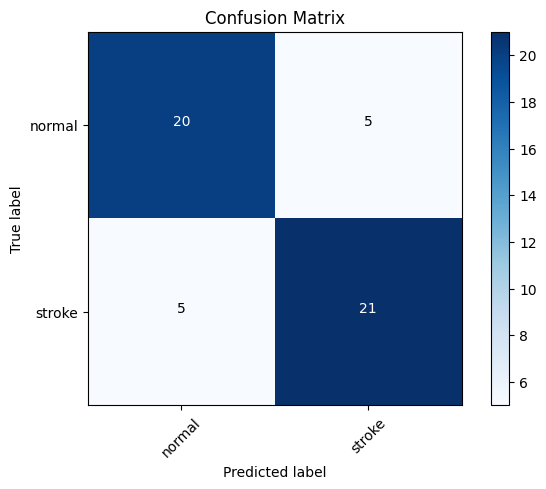

Test loss: 218.02432250976562, Test accuracy 0.8039215803146362


In [23]:
predictions = model_DNN.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# CNN

In [25]:
#scores_customCNN = []
#models_customCNN = []

lr = 0.0001

#conv_layers = param_grid3["conv_layers"][i[0]]
#dense_layers = param_grid3["dense_layers"][i[1]]
#epochs = param_grid3["epochs"][i[1]]
#print("Dense layers:", dense_layers)

model_customCNN = Sequential()
model_customCNN.add(Conv2D(
        filters=256,
        kernel_size=(6, 6),
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3),
    ))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))
model_customCNN.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN.add(Flatten())
model_customCNN.add(Dense(512, activation="relu"))
model_customCNN.add(Dense(units=2, activation="softmax"))

model_customCNN.summary()

model_customCNN.compile(
    optimizer=Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_customCNN.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
score = model_customCNN.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 465, 930, 256)     27904     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 116, 232, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 116, 232, 512)     10617344  
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 29, 58, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 29, 58, 512)       21234176  
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 7, 14, 512)     

c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


885/885 - 1244s - loss: 1.7251 - accuracy: 0.8801 - val_loss: 0.3301 - val_accuracy: 0.9060 - 1244s/epoch - 1s/step
Epoch 2/10
885/885 - 889s - loss: 0.0852 - accuracy: 0.9743 - val_loss: 0.3868 - val_accuracy: 0.9009 - 889s/epoch - 1s/step
Epoch 3/10
885/885 - 909s - loss: 0.0551 - accuracy: 0.9830 - val_loss: 1.2314 - val_accuracy: 0.8530 - 909s/epoch - 1s/step
Epoch 4/10
885/885 - 1040s - loss: 0.0820 - accuracy: 0.9799 - val_loss: 0.4882 - val_accuracy: 0.8991 - 1040s/epoch - 1s/step
Epoch 5/10
885/885 - 1036s - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.8476 - val_accuracy: 0.8632 - 1036s/epoch - 1s/step
Epoch 6/10
885/885 - 1070s - loss: 1.0911e-04 - accuracy: 1.0000 - val_loss: 1.0837 - val_accuracy: 0.8530 - 1070s/epoch - 1s/step
Epoch 7/10
885/885 - 1059s - loss: 3.9030e-06 - accuracy: 1.0000 - val_loss: 0.9131 - val_accuracy: 0.8735 - 1059s/epoch - 1s/step
Epoch 8/10
885/885 - 1036s - loss: 1.3393e-06 - accuracy: 1.0000 - val_loss: 0.9296 - val_accuracy: 0.8735 - 1036s/epo

Sensitivity: 0.9615384615384616
Specificity: 0.92
Confusion matrix, without normalization
[[23  2]
 [ 1 25]]


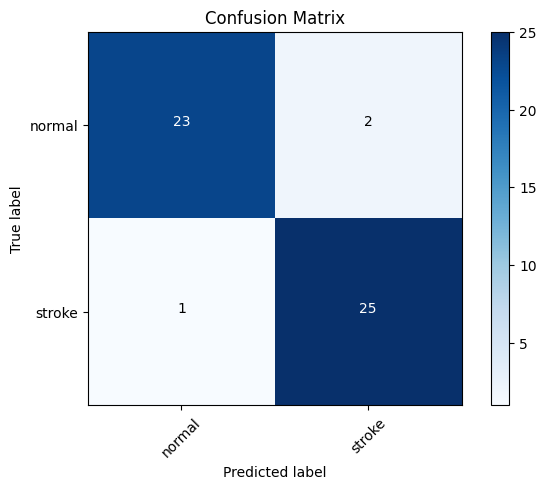

Test loss: 1.0338544845581055, Test accuracy 0.9411764740943909


In [26]:
predictions = model_customCNN.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# Pretrained Residual NN model (ResNet)

In [28]:
scores_resnet = []
models_resnet = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    # Create the base ResNet50 model
    base_model = ResNet152(weights="imagenet", include_top=False, input_shape=input_shape)

    # Add a global average pooling layer and a dense layer with softmax activation for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(layers):
        x = Dense(128, activation="relu")(x)
    predictions = Dense(2, activation="softmax")(x)

    # Define the model to be trained with the ResNet50 base and the classification layers added
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base ResNet50 layers so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with a learning rate of 0.001 and a categorical cross-entropy loss function
    model_resnet.compile(
        optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model_resnet.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)
    score = model_resnet.evaluate(test_batches, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))
    
    scores_resnet.append(score)
    models_resnet.append(model_resnet)

print(scores_resnet)


Learning rate: 0.0001
Layers: 1
Epoch 1/5


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


443/443 - 196s - loss: 0.2875 - accuracy: 0.8835 - val_loss: 0.3340 - val_accuracy: 0.9316 - 196s/epoch - 443ms/step
Epoch 2/5
443/443 - 198s - loss: 0.1667 - accuracy: 0.9386 - val_loss: 0.2867 - val_accuracy: 0.9179 - 198s/epoch - 446ms/step
Epoch 3/5
443/443 - 184s - loss: 0.1186 - accuracy: 0.9579 - val_loss: 0.2732 - val_accuracy: 0.9282 - 184s/epoch - 415ms/step
Epoch 4/5
443/443 - 184s - loss: 0.0855 - accuracy: 0.9765 - val_loss: 0.2516 - val_accuracy: 0.9350 - 184s/epoch - 414ms/step
Epoch 5/5
443/443 - 184s - loss: 0.0633 - accuracy: 0.9864 - val_loss: 0.2983 - val_accuracy: 0.9368 - 184s/epoch - 415ms/step
Test loss: 0.549350380897522, Test accuracy 0.8235294222831726
Learning rate: 0.0001
Layers: 2
Epoch 1/5
443/443 - 202s - loss: 0.3233 - accuracy: 0.8674 - val_loss: 0.2809 - val_accuracy: 0.9265 - 202s/epoch - 456ms/step
Epoch 2/5
443/443 - 192s - loss: 0.1694 - accuracy: 0.9344 - val_loss: 0.2614 - val_accuracy: 0.9419 - 192s/epoch - 433ms/step
Epoch 3/5
443/443 - 185s -

Test loss: 0.8709962368011475, Test accuracy: 0.843137264251709
Sensitivity: 0.8461538461538461
Specificity: 0.84
Confusion matrix, without normalization
[[21  4]
 [ 4 22]]


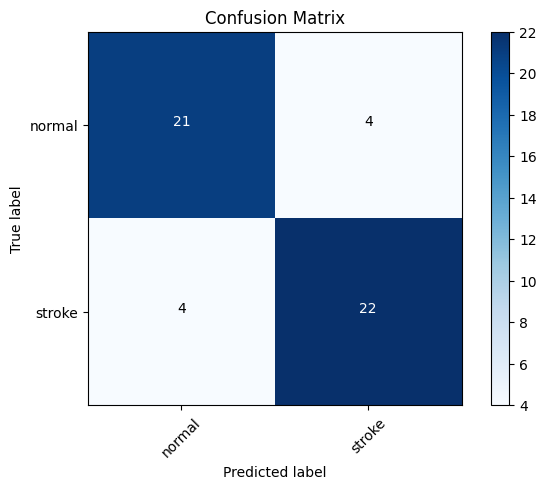

In [29]:
score = models_resnet[2].evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy: {}".format(score[0], score[1]))

predictions = models_resnet[2].predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

# SVM

In [13]:
#batch_size = 2
#
#for i in range(0, len(train_images), batch_size):
#    X_batch = train_images[i:i+batch_size]
#    y_batch = train_labels[i:i+batch_size]
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(train_images, train_labels)

#rbf_pred = rbf.predict(test_images)
#svm_score = classification_report(test_labels, rbf_pred)
#rbf_accuracy = accuracy_score(test_labels, rbf_pred)
#print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
#print(svm_score)

MemoryError: Unable to allocate 11.4 GiB for an array with shape (3537, 432450) and data type float64

In [ ]:
np.round(rbf_pred)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(rbf_pred, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

# SVM in keras using batches

In [6]:
model = Sequential(
    [
        Flatten(input_shape=input_shape),
        RandomFourierFeatures(
            output_dim=512, scale=15.0, kernel_initializer="gaussian"
        ),
        Dense(units=2, activation="softmax"),
    ]
)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="hinge",
    metrics=["accuracy"],
)

model.fit(train_batches, epochs=200, validation_data=valid_batches, verbose=2)

Epoch 1/200


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


885/885 - 36s - loss: 0.9993 - accuracy: 0.4982 - val_loss: 0.9919 - val_accuracy: 0.5248 - 36s/epoch - 41ms/step
Epoch 2/200
885/885 - 35s - loss: 0.9923 - accuracy: 0.5160 - val_loss: 0.9927 - val_accuracy: 0.5231 - 35s/epoch - 40ms/step
Epoch 3/200
885/885 - 39s - loss: 0.9857 - accuracy: 0.5290 - val_loss: 0.9937 - val_accuracy: 0.5179 - 39s/epoch - 44ms/step
Epoch 4/200
885/885 - 43s - loss: 0.9792 - accuracy: 0.5434 - val_loss: 0.9946 - val_accuracy: 0.5197 - 43s/epoch - 48ms/step
Epoch 5/200
885/885 - 35s - loss: 0.9731 - accuracy: 0.5536 - val_loss: 0.9954 - val_accuracy: 0.5145 - 35s/epoch - 40ms/step
Epoch 6/200
885/885 - 35s - loss: 0.9671 - accuracy: 0.5612 - val_loss: 0.9962 - val_accuracy: 0.5111 - 35s/epoch - 39ms/step
Epoch 7/200
885/885 - 35s - loss: 0.9615 - accuracy: 0.5663 - val_loss: 0.9969 - val_accuracy: 0.5043 - 35s/epoch - 39ms/step
Epoch 8/200
885/885 - 36s - loss: 0.9563 - accuracy: 0.5776 - val_loss: 0.9975 - val_accuracy: 0.4974 - 36s/epoch - 41ms/step
Epoc

Test loss: 1.0821040868759155, Test accuracy: 0.3921568691730499
Sensitivity: 0.4230769230769231
Specificity: 0.36
Confusion matrix, without normalization
[[ 9 16]
 [15 11]]


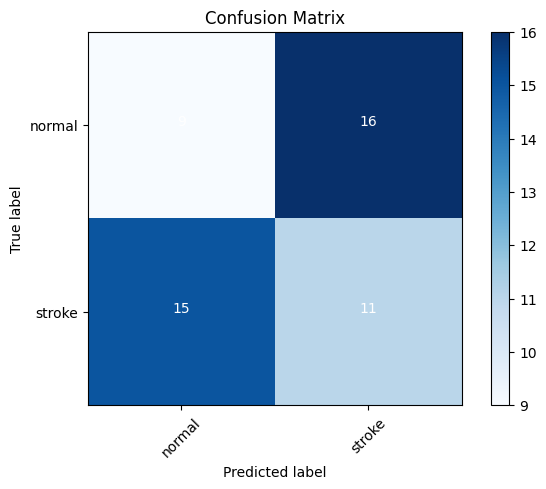

In [7]:
score = model.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy: {}".format(score[0], score[1]))

predictions = model.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")